In [1]:
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

In [6]:
# Load match data
data_file_name = 'match_data/match_data_euw1_10.12_100620.txt'
with open(data_file_name) as json_file:
    match_data_json = json.load(json_file)

# Load traits dictionary
with open('set3/traits.json') as json_file:
    ref_traits_json = json.load(json_file)

# Adding new traits by hand
ref_traits_json += [{'key':'Astro'}, {'key':'Battlecast'}, {'key':'Paragon'}]
ref_traits_index_dict = {ref_traits_json[i]['key']:i for i in range(len(ref_traits_json))}

In [9]:
# Transform traits data into vectors

def get_traits_as_vector(participant: dict):
    traits_list = participant['traits']
    traits = np.zeros(len(ref_traits_index_dict))
    for i in traits_list:
        if i['name'] != 'TemplateTrait':
            traits[ref_traits_index_dict[i['name']]] = i['tier_current']
    return traits

traits_data_vectors = []
for i in match_data_json:
    for j in i['info']['participants']:
        traits_data_vectors.append(get_traits_as_vector(j))
traits_data_vectors = np.array(traits_data_vectors)

In [10]:
# Collect identical traits vectors to reduce input size into clustering
# This step doesn't affect HCA, but would affect the outcome of ex. K-means, since I am removing multiple occurences

unique_vectors_dict = {}
index = 0
for i in traits_data_vectors:
    traits_str = ''.join([str(int(j)) for j in i])
    if traits_str in unique_vectors_dict:
        pass
    else:
        unique_vectors_dict[traits_str] = index
        index += 1

traits_data_vectors_unique = []
for i in list(unique_vectors_dict.keys()):
    traits_data_vectors_unique.append([float(j) for j in list(i)])
traits_data_vectors_unique = np.array(traits_data_vectors_unique)

unique_to_original_mapping = []
for i in traits_data_vectors:
    traits_str = ''.join([str(int(j)) for j in i])
    unique_to_original_mapping.append(unique_vectors_dict[traits_str])

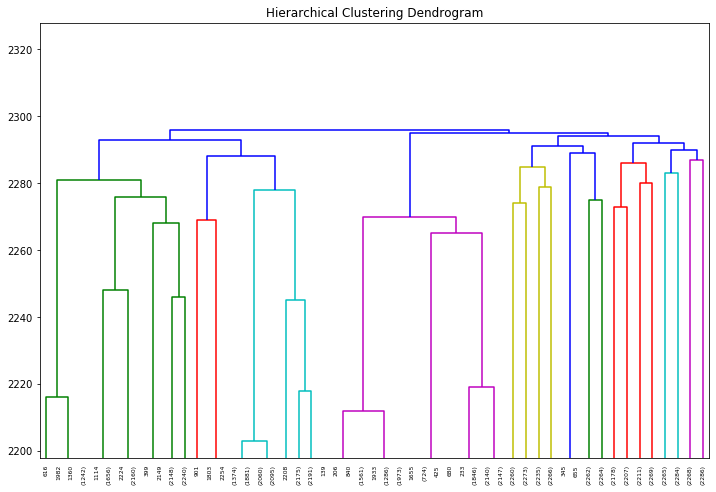

In [11]:
# Building an Agglomerative HC model

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def HCA_label_matrix(model):
    children = model.children_
    n = model.n_leaves_
    label_matrix = np.zeros((n, n))
    label_matrix[0] = np.arange(n)
    for i in range(1,n):
        label_matrix[i] = label_matrix[i-1]
        merging_clusters = children[i-1]
        for j in range(n):
            if label_matrix[i][j] == merging_clusters[0] or label_matrix[i][j] == merging_clusters[1]:
                label_matrix[i][j] = i+n-1
    return label_matrix

HC_model = AgglomerativeClustering(affinity='l1', linkage='average').fit(traits_data_vectors_unique)
label_matrix = HCA_label_matrix(HC_model)

# Transform label matrix back to labels for original data
label_matrix_original = np.zeros((len(traits_data_vectors_unique), len(traits_data_vectors)))
for i in range(len(traits_data_vectors_unique)):
    label_matrix_original[i] = [label_matrix[i][j] for j in unique_to_original_mapping]

# Plots 10 clusters colored by default
plt.figure(figsize=(12,8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(HC_model, truncate_mode='level', p=5, color_threshold=HC_model.n_leaves_-10)
plt.ylim(HC_model.n_leaves_ - 100, HC_model.n_leaves_ + 30)
plt.show()

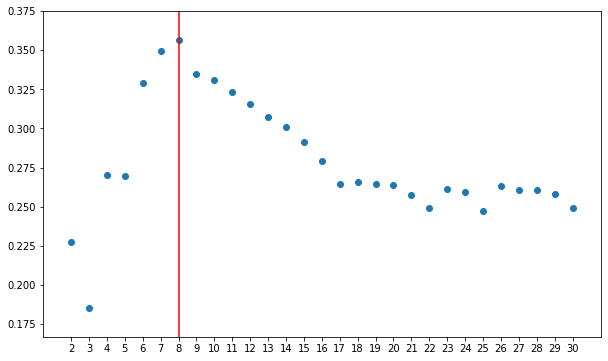

In [12]:
# Choosing the optimal number of clusters based on silhouette score

n_range = 30
n_clusters = range(2,n_range+1)
n_silhouette_score = []
for i in n_clusters:
    n_silhouette_score.append(metrics.silhouette_score(traits_data_vectors, label_matrix_original[len(label_matrix_original)-i], metric='l1'))

plt.figure(figsize=(10,6))
plt.xticks(range(2, n_range+1))
plt.scatter(n_clusters, n_silhouette_score)
plt.axvline(x=n_clusters[n_silhouette_score.index(max(n_silhouette_score))], color='r')
#plt.axvline(x=10, color='g')

# The maximum score is shown in red line. Either choose this point or choose another graphically. 

In [13]:
# Compute cluster means

def traits_vector_to_text(v, rounding=1):
    v = np.round(v,1)
    trait_names = list(ref_traits_index_dict.keys())
    v_text = []
    for i in range(len(v)):
        if v[i] > 0:
            v_text.append((trait_names[i], v[i]))
    v_text.sort(key=lambda tup: tup[1], reverse=True)
    v_text = [i[0] + '_' + str(i[1]) for i in v_text]
    return v_text

#Input the optimal n_cluster here
n_cluster = 8
labels = label_matrix_original[len(label_matrix_original)-n_cluster]
cluster_id = set(labels)
cluster_means_dict = {}
for i in cluster_id:
    traits_in_cluster = []
    for j in range(len(labels)):
        if labels[j] == i:
            traits_in_cluster.append(traits_data_vectors[j])
    traits_in_cluster = np.array(traits_in_cluster)
    cluster_mean = np.mean(traits_in_cluster, axis=0)
    cluster_means_dict[i] = traits_vector_to_text(cluster_mean)
    #print(traits_vector_to_text(cluster_mean))    

In [14]:
# Adding comp id to the data and saving it
k = 0
for i in range(len(match_data_json)):
    for j in range(8):
        match_data_json[i]['info']['participants'][j]['comp'] = labels[k]
        k += 1

with open(data_file_name, 'w') as json_file:
    json.dump(match_data_json, json_file)

with open(data_file_name[:-4] + '_comp.txt', 'w') as json_file:
    json.dump(cluster_means_dict, json_file)